## 🛍️ Mall Customer Segmentation Project – Summary


The goal of this project was to segment mall customers into meaningful groups based on their **Age, Annual Income, and Spending Score**.  
This helps the mall management design targeted marketing strategies and improve customer satisfaction.

##  Importing Libraries

In this step, we import all the necessary Python libraries for the project:

- **pandas, numpy** → for data handling and numerical computations  
- **matplotlib, seaborn** → for data visualization (EDA and plots)  
- **sklearn.preprocessing** (LabelEncoder, StandardScaler) → to encode categorical values and scale numerical features  
- **sklearn.model_selection** → to split data, perform cross-validation, and hyperparameter tuning  
- **sklearn.metrics** → to evaluate models (accuracy, F1, confusion matrix, silhouette score, Davies-Bouldin index, etc.)  
- **sklearn.cluster** → clustering algorithms (KMeans, Hierarchical, DBSCAN)  
- **mpl_toolkits.mplot3d** → for 3D visualizations of clusters  
- **joblib** → for saving/loading models  
- **warnings** → to suppress unnecessary warnings  

These imports set up the foundation for the entire customer segmentation project, enabling us to preprocess data, build clustering models, evaluate performance, and visualize results effectively.


In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
import warnings
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score


## Data Loading and Understanding

In [246]:
m=pd.read_csv("Mall_Customers.csv")


In [247]:
m.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [248]:
m.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [249]:
m.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [250]:
m.nunique()

CustomerID                200
Gender                      2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
dtype: int64

In [251]:
m.shape

(200, 5)

In [252]:
m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [253]:
m.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [254]:
m.columns.tolist()

['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [255]:
m.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

## Data Cleaning

In [256]:
m.rename(columns={'Annual Income (k$)': 'Annual Income','Spending Score (1-100)': 'Spending Score'}, inplace=True)
m.head()

,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [257]:
m = m.drop(columns=["CustomerID"])

In [258]:
m.head()

,Gender,Age,Annual Income,Spending Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [259]:
m= m.drop_duplicates().reset_index(drop=True)

In [260]:
m.shape

(200, 4)

##  Exploring Categorical Features

In this step, we check all **categorical columns** (object data types) in the dataset.  
For each column, we print the **top 10 most frequent values** along with their counts.  

This helps us:  
- Understand the distribution of categorical variables  
- Detect any dominant or rare categories  
- Decide later whether to encode, group, or drop certain categories during preprocessing  


In [261]:
for c in m.select_dtypes(include=['object']).columns:
    print(f"\nTop values for '{c}':\n", m[c].value_counts().head(10))



Top values for 'Gender':
 Gender
Female    112
Male       88
Name: count, dtype: int64


##  Cleaning Categorical Features  

Here, we clean all categorical (object type) columns:  

- `.astype(str)` → Ensures all entries are strings (avoids issues with mixed types).  
- `.str.strip()` → Removes unwanted leading/trailing spaces in text values.  

👉 This step is important because extra spaces (e.g., `" Male"` vs `"Male"`) would be treated as **different categories**, which can cause incorrect encoding or misleading analysis later.  


In [262]:
for c in m.select_dtypes(include=['object']).columns:
    m[c] = m[c].astype(str).str.strip()

In [263]:
before = m.shape[0]
m= m.drop_duplicates().reset_index(drop=True)
after = m.shape[0]
print(f"\nDropped {before - after} duplicate rows")


Dropped 0 duplicate rows


In [264]:
print("\nCleaned data shape:", m.shape)
print("Remaining columns:", m.columns.tolist())
print("\nFirst 5 cleaned rows:\n", m.head())


Cleaned data shape: (200, 4)
Remaining columns: ['Gender', 'Age', 'Annual Income', 'Spending Score']

First 5 cleaned rows:
    Gender  Age  Annual Income  Spending Score
0    Male   19             15              39
1    Male   21             15              81
2  Female   20             16               6
3  Female   23             16              77
4  Female   31             17              40


##  Encoding Categorical Variables  

We convert the `Gender` column into numeric values for modeling:  

- `"Male"` → **0**  
- `"Female"` → **1**  

👉 This step is required because most ML algorithms (like K-Means) work only with numerical data, not text labels.  

In [265]:
m["Gender"] = m["Gender"].map({"Male": 0, "Female": 1})
m.head()

,Gender,Age,Annual Income,Spending Score
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


## EXPLORATORY DATA ANALYTICS

## Univariate Analysis 
Age Distribution  

This histogram shows the distribution of customer ages in the dataset.  

- The **x-axis** represents the age of customers.  
- The **y-axis** represents the number of customers in each age group.  
- A **Kernel Density Estimate (KDE)** curve is overlaid to show the smooth probability distribution.  

👉 This helps us understand the **age demographics** of mall customers and identify which age groups dominate.  


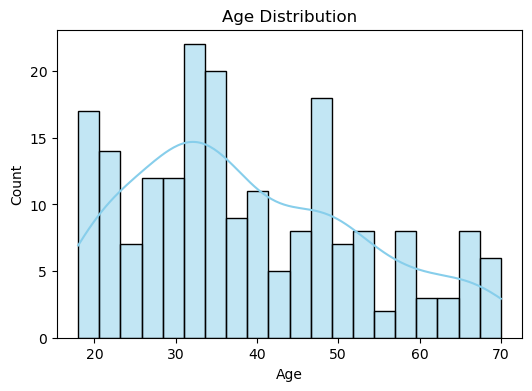

In [266]:
plt.figure(figsize=(6,4))
sns.histplot(m["Age"], bins=20, kde=True, color="skyblue")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

Annual Income Distribution  

This plot shows how customer annual incomes are distributed.  
- Most customers fall within a middle-income range.  
- Helps identify **low, medium, and high-income groups** for segmentation.  

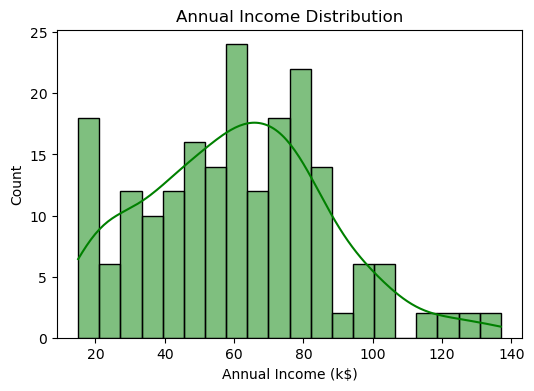

In [267]:
plt.figure(figsize=(6,4))
sns.histplot(m["Annual Income"], bins=20, kde=True, color="green")
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Count")
plt.show()


Spending Score Distribution  

This chart displays how customers are spread across spending scores (1–100).  
- The distribution shows both **low spenders and high spenders**, with many in between.  
- Useful for separating **budget vs premium** customers.  

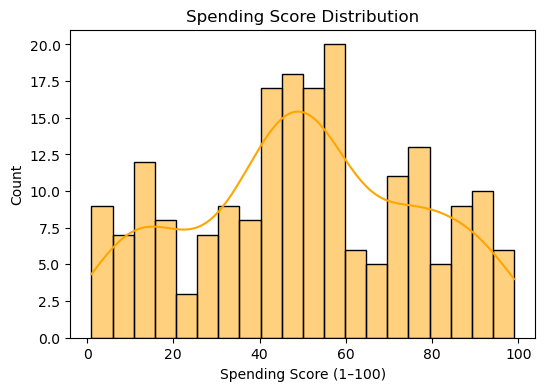

In [268]:
plt.figure(figsize=(6,4))
sns.histplot(m["Spending Score"], bins=20, kde=True, color="orange")
plt.title("Spending Score Distribution")
plt.xlabel("Spending Score (1–100)")
plt.ylabel("Count")
plt.show()

Gender Distribution  

This chart shows the count of male vs female customers.  
- The dataset is relatively **balanced** between genders.  
- Ensures clustering results won’t be biased toward one gender group.  

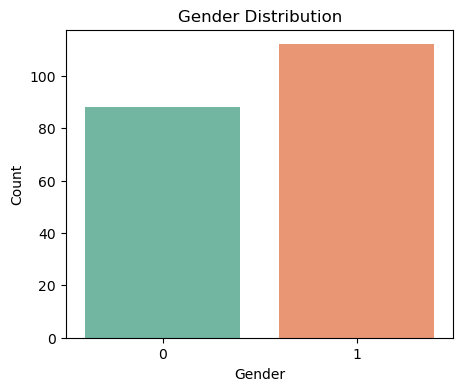

In [269]:
plt.figure(figsize=(5,4))
sns.countplot(x="Gender", data=m, palette="Set2")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

## Bivariate Analysis 

Annual Income vs Spending Score  

This scatter plot shows how **Annual Income** relates to **Spending Score**, with colors representing gender.  
- Clear **clusters start to emerge** (e.g., high income–high spenders vs low income–low spenders).  
- Gender distribution appears **even across groups**, suggesting spending is not strongly tied to gender.  

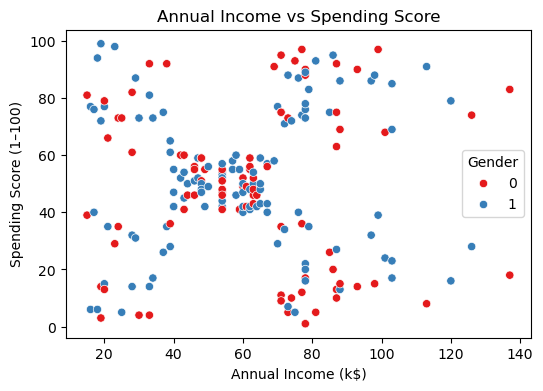

In [270]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="Annual Income", y="Spending Score", data=m, hue="Gender", palette="Set1")
plt.title("Annual Income vs Spending Score")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1–100)")
plt.show()

Age vs Spending Score  

This scatter plot compares **Age** and **Spending Score**, with gender as a hue.  
- Younger customers tend to have **higher spending scores**, indicating they are more active shoppers.  
- Older age groups show **lower spending scores**, suggesting more conservative spending habits.  
- Gender differences remain minimal in spending behavior across ages.  

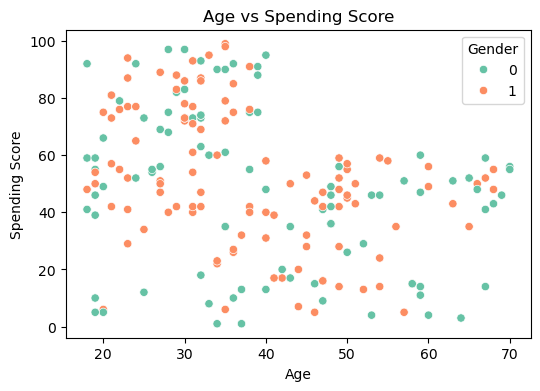

In [271]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="Age", y="Spending Score", data=m, hue="Gender", palette="Set2")
plt.title("Age vs Spending Score")
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.show()

Average Spending Score by Gender  

This bar plot shows the **average spending score for Male and Female customers**:  
- Both genders have **comparable spending behaviors**, with only slight differences.  
- Indicates that **gender is not a strong differentiator** in spending habits compared to other features like income or age.  

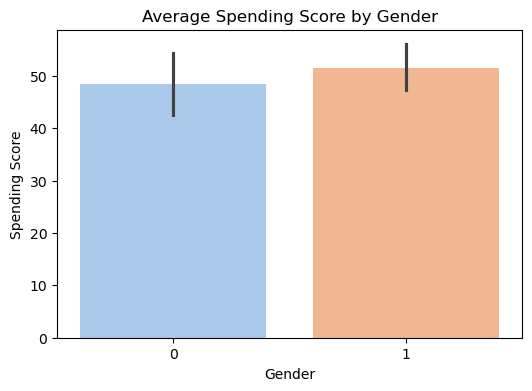

In [272]:
plt.figure(figsize=(6,4))
sns.barplot(x="Gender", y="Spending Score", data=m, estimator="mean", palette="pastel")
plt.title("Average Spending Score by Gender")
plt.show()

Age vs Annual Income (Trend)  

This regression plot shows the relationship between **Age and Annual Income**:  
- The trend line suggests a **slightly positive correlation** between age and income.  
- Younger customers tend to have **lower incomes**, while middle-aged groups show **higher earning potential**.  
- However, variation exists, indicating other factors (like profession, lifestyle) may also influence income.  

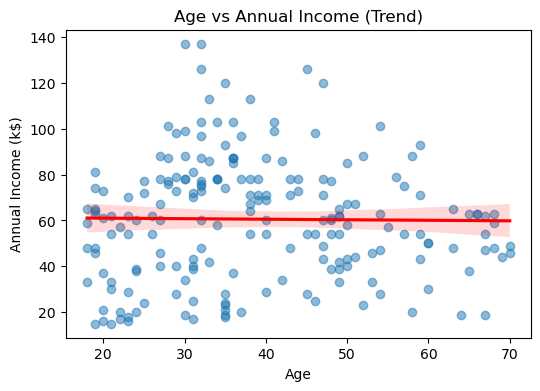

In [273]:
plt.figure(figsize=(6,4))
sns.regplot(x="Age", y="Annual Income", data=m, scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
plt.title("Age vs Annual Income (Trend)")
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
plt.show()

##  Multivariate Analysis 
3D Scatter Plot (Age, Income, Spending Score)  

This 3D scatter plot visualizes the relationship among **Age, Annual Income, and Spending Score**:  
- Customers form **visible clusters** when considering all three variables together.  
- High-income and high-spending customers stand out as a separate group (potential premium customers).  
- Younger customers with **moderate income but high spending** are also visible.  
- This visualization helps in identifying **natural groupings** in data, which is crucial for clustering.  

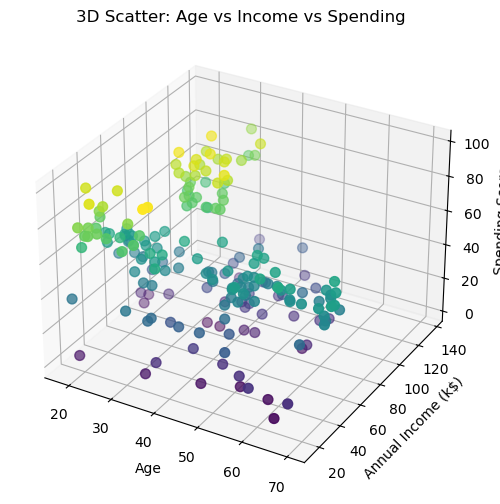

In [274]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(m["Age"], m["Annual Income"], m["Spending Score"], c=m["Spending Score"], cmap="viridis", s=50)
ax.set_xlabel("Age")
ax.set_ylabel("Annual Income (k$)")
ax.set_zlabel("Spending Score")
plt.title("3D Scatter: Age vs Income vs Spending")
plt.show()

Pairplot by Gender  

The pairplot shows **pairwise relationships** among Age, Annual Income, Spending Score, and Gender:  
- Each scatter plot reveals how two features relate, while the diagonal shows feature distributions.  
- Clear **clusters emerge** in the Income vs Spending Score plots, hinting at potential customer segments.  
- Gender-based color coding helps identify whether spending patterns differ significantly between males and females.  
- This plot provides a **holistic view** of feature interactions before clustering.  

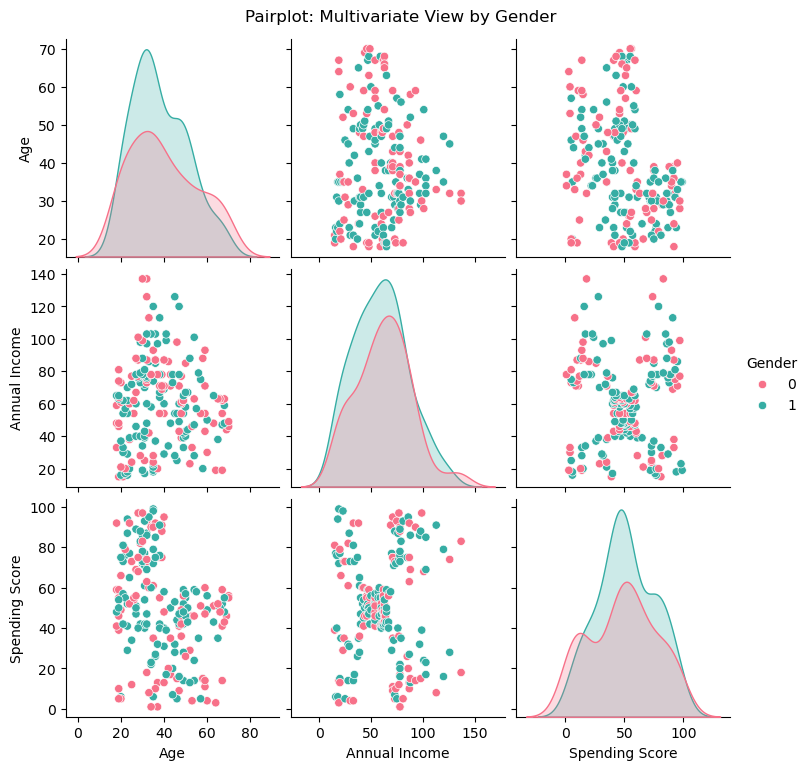

In [275]:
sns.pairplot(m[["Age","Annual Income","Spending Score","Gender"]], hue="Gender", diag_kind="kde", palette="husl")
plt.suptitle("Pairplot: Multivariate View by Gender", y=1.02)
plt.show()

Correlation Heatmap  

The heatmap displays the **correlation matrix** of Age, Annual Income, and Spending Score:  
- Age has a weak **negative correlation** with Spending Score (older customers spend slightly less).  
- Annual Income and Spending Score show **very low correlation**, indicating income alone does not drive spending.  
- Age and Annual Income are also weakly correlated, suggesting diverse income levels across age groups.  
- Overall, correlations are not strong, which justifies the use of **clustering** to discover hidden patterns.  

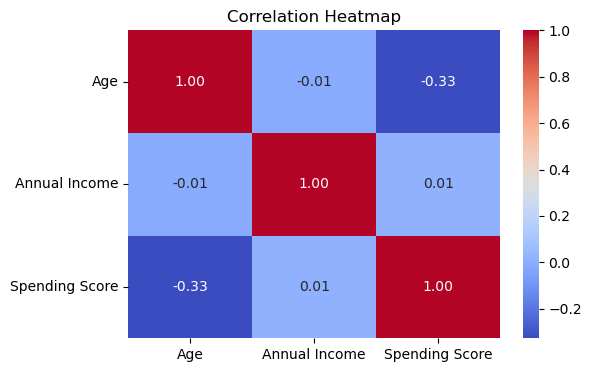

In [276]:
plt.figure(figsize=(6,4))
sns.heatmap(m[["Age","Annual Income","Spending Score"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Spending Score by Income Range & Gender  

This **boxplot** shows how customer spending varies across different income ranges, separated by gender:  

- **Low Income**: Spending scores are spread out, with no clear pattern between genders.  
- **Medium Income**: Both male and female customers show a wider range of spending, indicating mixed behavior.  
- **High Income**: Females tend to have slightly higher spending scores, while males show more moderate spending.  

👉 This visualization highlights that **income is not the only factor** influencing spending; **gender and lifestyle preferences** also play a role.  

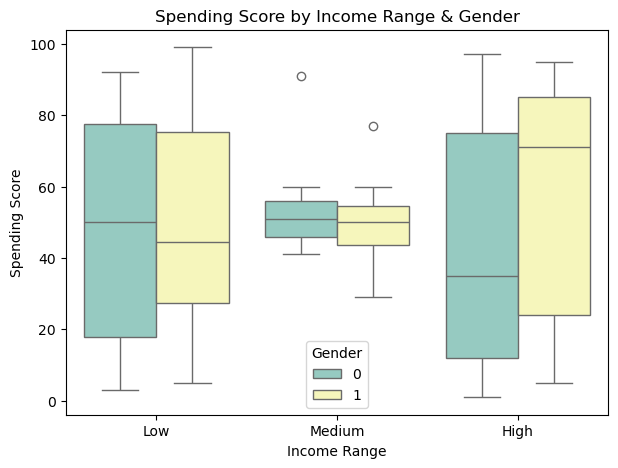

In [277]:
m["Income Range"] = pd.cut(m["Annual Income"], bins=[0,40,70,150], labels=["Low","Medium","High"])

plt.figure(figsize=(7,5))
sns.boxplot(x="Income Range", y="Spending Score", hue="Gender", data=m, palette="Set3")
plt.title("Spending Score by Income Range & Gender")
plt.show()

##  Feature Selection for Clustering  

Here we select the key features: **Age, Annual Income, and Spending Score** for clustering.  

- **Age** → Represents customer demographics.  
- **Annual Income** → Indicates financial capacity.  
- **Spending Score** → Reflects purchasing behavior.  

👉 These three variables are chosen because they best capture **customer segmentation patterns**, making them ideal for clustering analysis.  

In [278]:
X = m[['Age', 'Annual Income','Spending Score']]

Feature Scaling  

Before applying clustering algorithms, we need to **scale the features** because variables like *Annual Income* and *Spending Score* have different ranges.  

- We use **StandardScaler**, which standardizes data by removing the mean and scaling to unit variance.  
- This ensures that **all features contribute equally** to distance-based clustering algorithms like K-Means.  

In [279]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Verification of Scaled Data  

- We check the **shape** of the feature matrix to confirm the dataset is correctly transformed into numerical format suitable for clustering.  
- Displaying the **first 5 scaled rows** ensures that scaling worked as expected (values are standardized around 0).  
- This step validates preprocessing before applying clustering algorithms like K-Means.  

In [280]:
print("Shape of feature matrix:", X_scaled.shape)
print("First 5 scaled rows:\n", X_scaled[:5])

Shape of feature matrix: (200, 3)
First 5 scaled rows:
 [[-1.42456879 -1.73899919 -0.43480148]
 [-1.28103541 -1.73899919  1.19570407]
 [-1.3528021  -1.70082976 -1.71591298]
 [-1.13750203 -1.70082976  1.04041783]
 [-0.56336851 -1.66266033 -0.39597992]]


##  Elbow Method – Finding Optimal Clusters (k)

- We calculate **WCSS (Within-Cluster Sum of Squares)** for different values of `k` (2–10).  
- WCSS measures how compact the clusters are (lower is better).  
- By plotting WCSS vs `k`, we can apply the **Elbow Method** to identify the optimal number of clusters where the rate of decrease slows down ("elbow point").  

In [307]:
wcss = []  
K = range(2, 11)  
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

Elbow Curve for Optimal Cluster Selection  

- The plot shows **WCSS (Within-Cluster Sum of Squares)** vs **number of clusters (k)**.  
- The "elbow point" (where the curve starts flattening) indicates the **optimal number of clusters**.  
- This ensures a balance between compact clusters and not overfitting with too many groups.  

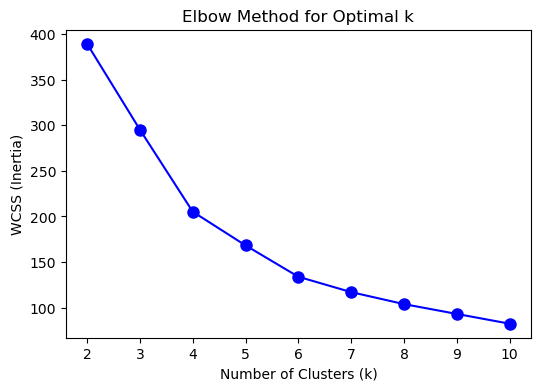

In [282]:
plt.figure(figsize=(6,4))
plt.plot(K, wcss, 'bo-', markersize=8)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()

##  Silhouette Score for Cluster Validation  

- The **Silhouette Score** measures how well-separated and cohesive clusters are.  
- Values range from **-1 to 1**:  
  - **Close to 1** → Well-defined clusters.  
  - **Around 0** → Overlapping clusters.  
  - **Negative** → Incorrect clustering.  
- By testing different values of **k (2–6)**, we identify which number of clusters gives the **highest silhouette score**, helping confirm the optimal k for segmentation.  


In [283]:
for k in range(2, 7):  
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score for k={k}: {score:.3f}")

Silhouette Score for k=2: 0.335
Silhouette Score for k=3: 0.358
Silhouette Score for k=4: 0.404
Silhouette Score for k=5: 0.417
Silhouette Score for k=6: 0.428


##  Final K-Means Clustering  

- Applied **K-Means with k=5 clusters** (based on Elbow + Silhouette insights).  
- Each customer is now assigned a **cluster label (0–4)** in the dataset.  
- This segmentation forms the basis for profiling customer groups.  

In [284]:
kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=10)
m["cluster"] = kmeans_final.fit_predict(X_scaled)

In [285]:
print("\nCluster assignments added to dataset:")
print(m.head())


Cluster assignments added to dataset:
   Gender  Age  Annual Income  Spending Score Income Range  cluster
0       0   19             15              39          Low        1
1       0   21             15              81          Low        1
2       1   20             16               6          Low        0
3       1   23             16              77          Low        1
4       1   31             17              40          Low        1


##  WCSS (Inertia) of Final Clustering  

- The **WCSS (Within-Cluster Sum of Squares)** for the final K-Means model (k=5) is **168.25**.  
- This value represents how compact the clusters are — lower WCSS means customers within a cluster are more similar.  
- While WCSS alone does not confirm the "best" k, when combined with the **Elbow Method** and **Silhouette Score**, it helps validate that our chosen 5 clusters provide a meaningful segmentation.  


In [286]:
print("WCSS (Inertia):", kmeans_final.inertia_)

WCSS (Inertia): 168.24758017556837


Silhouette Score of Final Model  

- The **Silhouette Score** for the chosen K-Means model (k=5) is **0.417**.  
- Interpretation:  
  - Scores closer to **1** → well-separated clusters.  
  - Around **0.4–0.5** → reasonably good structure (moderately distinct clusters).  
  - Below **0.2** → weak clustering.  
- Thus, our model shows a **fairly good cluster separation**, making the segmentation meaningful for business insights.  

In [287]:
sil_score = silhouette_score(X_scaled, kmeans_final.labels_)
print("Silhouette Score:", sil_score)


Silhouette Score: 0.41664341513732767


##  Cluster Evaluation – Davies-Bouldin Index & Visualization  

- The **Davies-Bouldin Index (DBI)** for our K-Means model (k=5) is **0.87**.  
- A **lower DBI** indicates better clustering (clusters are compact and well-separated).  
- A DBI below **1.0** is generally considered good, which means our clusters are meaningful.  

### Visualization: Age vs Annual Income (Colored by Cluster)  
- The scatter plot shows how clusters are distributed across **Age** and **Annual Income**.  
- We can see distinct groups forming, which validates that customers are segmented into meaningful profiles.  


Davies-Bouldin Index: 0.874551051002418


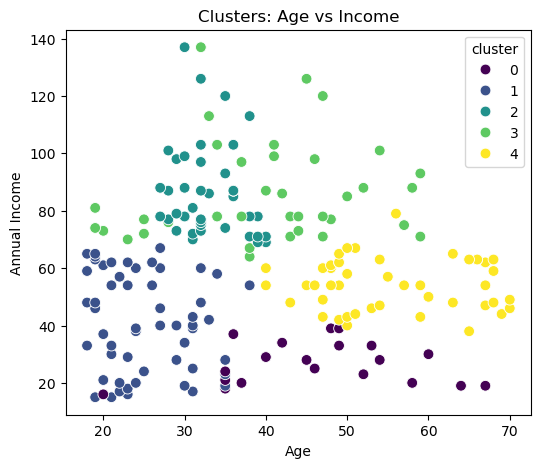

In [288]:
db_index = davies_bouldin_score(X_scaled, kmeans_final.labels_)
print("Davies-Bouldin Index:", db_index)
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=m["Age"], y=m["Annual Income"], hue=m["cluster"], palette="viridis", s=60
)
plt.title("Clusters: Age vs Income")
plt.xlabel("Age")
plt.ylabel("Annual Income")
plt.show()

###  Clusters:Income vs Spending  

This scatter plot highlights how customers are grouped based on **Annual Income** and **Spending Score**:  

- **High Income – High Spending** → Premium Customers 💎  
- **Low Income – Low Spending** → Budget Customers 💰  
- **High Income – Low Spending** → Potential customers needing engagement 🎯  
- **Other groups** → Moderate income and spending behavior  

✅ This visualization is one of the most **business-relevant cluster views**, as it directly reflects purchasing power and spending habits. 

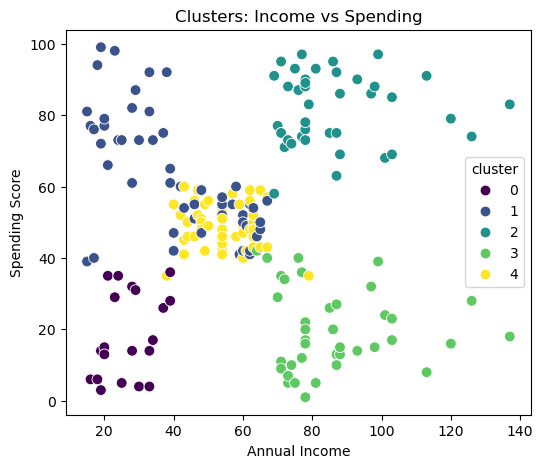

In [289]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=m["Annual Income"], y=m["Spending Score"], hue=m["cluster"], palette="viridis", s=60
)
plt.title("Clusters: Income vs Spending")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()


### Clusters: Age vs Spending  

This plot shows how clusters differ based on **Age** and **Spending Score**:  

- Younger customers with **high spending scores** → Likely **impulsive buyers / trend followers**.  
- Older customers with **low spending scores** → More **budget-conscious / loyal but less active shoppers**.  
- Middle-aged groups show **mixed behavior**, depending on income and lifestyle.  

✅ This helps in identifying **age-specific marketing strategies**, such as targeting young high spenders with social media ads or engaging older low spenders with loyalty programs.  

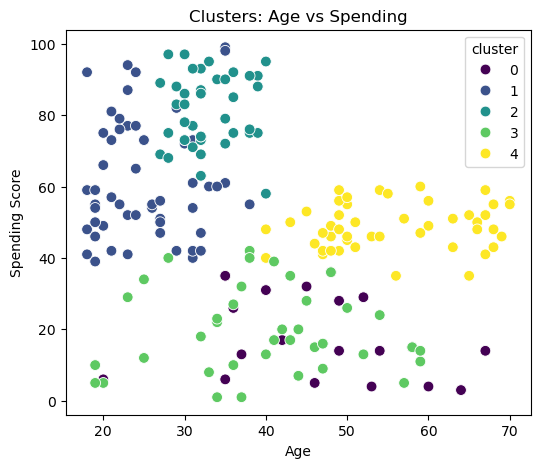

In [290]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=m["Age"], y=m["Spending Score"], hue=m["cluster"], palette="viridis", s=60
)
plt.title("Clusters: Age vs Spending")
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.show()

###  3D Cluster Visualization  

This 3D scatter plot visualizes clusters across **Age**, **Annual Income**, and **Spending Score** simultaneously.  

- It provides a **comprehensive view** of how clusters are separated in the feature space.  
- Distinct groups of customers can be clearly identified, showing variations in **spending patterns** and **income levels** across different age brackets.  
- This visualization confirms that clusters are not only visible in 2D plots but also hold true when considering multiple features together.  

✅ Useful for validating the **overall segmentation quality** before moving to business interpretation.  


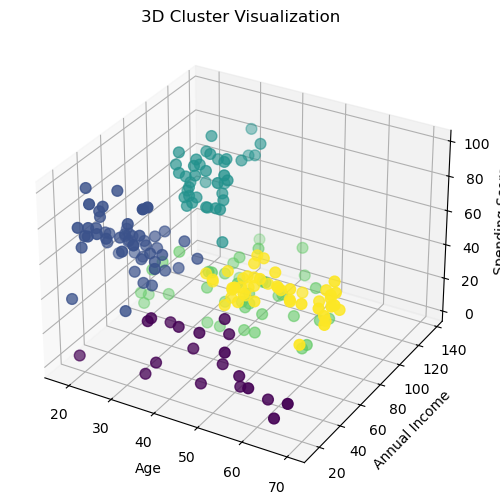

In [291]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    m["Age"], m["Annual Income"], m["Spending Score"],
    c=m["cluster"], cmap="viridis", s=60
)
ax.set_xlabel("Age")
ax.set_ylabel("Annual Income ")
ax.set_zlabel("Spending Score")
ax.set_title("3D Cluster Visualization")
plt.show()

### Silhouette Score for Optimal k  
The **Silhouette Score** (range: -1 to +1) shows how well data points fit into clusters.  
- Higher score → better clustering.  
By plotting scores for k=2–10, we find the **best k** where the score is maximum.  


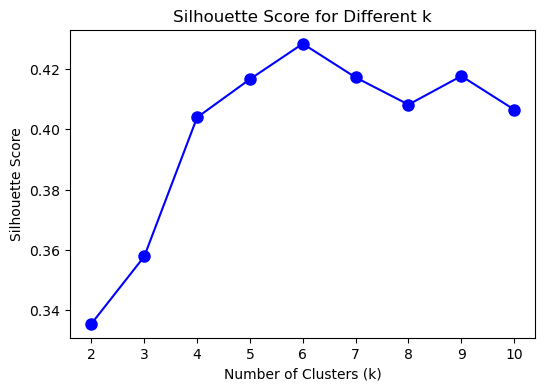

Best number of clusters (k): 6


In [292]:
sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(K, sil_scores, "bo-", markersize=8)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different k")
plt.show()

best_k = K[sil_scores.index(max(sil_scores))]
print("Best number of clusters (k):", best_k)

### Model Comparison (K-Means vs Agglomerative vs DBSCAN)  
- **K-Means & Agglomerative** → Compared using **Silhouette Score**.  
- **DBSCAN** → Works without specifying clusters, but may form only 1 cluster or noise.  
This step checks which algorithm gives the most meaningful segmentation.  


from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)
score_kmeans = silhouette_score(X_scaled, labels_kmeans)
print(f"K-Means - Silhouette Score: {score_kmeans:.3f}")


agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
labels_agg = agg.fit_predict(X_scaled)
score_agg = silhouette_score(X_scaled, labels_agg)
print(f"Agglomerative - Silhouette Score: {score_agg:.3f}")
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

if len(set(labels_dbscan)) > 1 and -1 not in set(labels_dbscan):
    score_dbscan = silhouette_score(X_scaled, labels_dbscan)
    print(f"DBSCAN - Silhouette Score: {score_dbscan:.3f}")
else:
    print("DBSCAN formed only 1 cluster or mostly noise")


### Alternative Clustering Methods (Hierarchical & DBSCAN)  
- **Hierarchical Clustering** → Evaluated with Silhouette Score to check compactness & separation.  
- **DBSCAN** → Density-based method, useful for irregular cluster shapes.  
  - If it forms only 1 cluster → need to tune parameters (`eps`, `min_samples`).  
This step ensures we compare different algorithms beyond K-Means.  


In [294]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN

hier = AgglomerativeClustering(n_clusters=best_k)
labels_hier = hier.fit_predict(X_scaled)
print("Hierarchical Silhouette Score:", silhouette_score(X_scaled, labels_hier))


dbscan = DBSCAN(eps=0.8, min_samples=5)  
labels_db = dbscan.fit_predict(X_scaled)

if len(set(labels_db)) > 1:
    print("DBSCAN Silhouette Score:", silhouette_score(X_scaled, labels_db))
else:
    print("DBSCAN only found 1 cluster (try tuning eps/min_samples).")


Hierarchical Silhouette Score: 0.4201169558789579
DBSCAN Silhouette Score: 0.2543987042290558


### Model Comparison (K-Means vs Hierarchical vs DBSCAN)

- We compared clustering algorithms using **Silhouette Score**, **Davies-Bouldin Index**, and the **number of clusters** formed.  
- **K-Means & Hierarchical** generally produce well-separated clusters.  
- **DBSCAN** may fail (only 1 cluster or noise) if parameters are not tuned properly.  

The comparison table helps identify which algorithm gives the most **meaningful customer segments** for business insights.  


In [295]:
results = {}
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)
results["KMeans"] = {
    "Silhouette": silhouette_score(X_scaled, labels_kmeans),
    "Davies-Bouldin": davies_bouldin_score(X_scaled, labels_kmeans),
    "Clusters": len(set(labels_kmeans))
}


hier = AgglomerativeClustering(n_clusters=best_k)
labels_hier = hier.fit_predict(X_scaled)
results["Hierarchical"] = {
    "Silhouette": silhouette_score(X_scaled, labels_hier),
    "Davies-Bouldin": davies_bouldin_score(X_scaled, labels_hier),
    "Clusters": len(set(labels_hier))
}

dbscan = DBSCAN(eps=0.8, min_samples=5) 
labels_db = dbscan.fit_predict(X_scaled)
if len(set(labels_db)) > 1:
    results["DBSCAN"] = {
        "Silhouette": silhouette_score(X_scaled, labels_db),
        "Davies-Bouldin": davies_bouldin_score(X_scaled, labels_db),
        "Clusters": len(set(labels_db))
    }
else:
    results["DBSCAN"] = {"Silhouette": None, "Davies-Bouldin": None, "Clusters": 1}

comparison = pd.DataFrame(results).T
print("\nModel Comparison:\n", comparison)



Model Comparison:
              Silhouette  Davies-Bouldin  Clusters
KMeans          0.428417        0.825354       6.0
Hierarchical    0.420117        0.852102       6.0
DBSCAN          0.254399        4.289707       2.0


###  Cluster Profiling

- Calculated mean **Age, Income, Spending Score** per cluster.  
- Assigned business labels:  
  - Premium → High income & spending  
  - Budget → Low income & spending  
  - Potential → High income, low spending  
  - Moderate → Middle range customers  


In [296]:
m["Cluster"] = kmeans.labels_

cluster_profile = m.groupby("Cluster")[["Age","Annual Income","Spending Score"]].mean().round(2)

def segment_name(row):
    if row["Annual Income"] > 70 and row["Spending Score"] > 60:
        return "Premium Customers"
    elif row["Annual Income"] < 40 and row["Spending Score"] < 40:
        return "Budget Customers"
    elif row["Annual Income"] > 70 and row["Spending Score"] < 40:
        return "High Income - Low Spending (Potential)"
    else:
        return "Moderate / Middle Segment"

cluster_profile["Segment Name"] = cluster_profile.apply(segment_name, axis=1)

print(cluster_profile)


           Age  Annual Income  Spending Score  \
Cluster                                         
0        56.33          54.27           49.07   
1        26.79          57.10           48.13   
2        41.94          88.94           16.97   
3        32.69          86.54           82.13   
4        25.00          25.26           77.61   
5        45.52          26.29           19.38   

                                   Segment Name  
Cluster                                          
0                     Moderate / Middle Segment  
1                     Moderate / Middle Segment  
2        High Income - Low Spending (Potential)  
3                             Premium Customers  
4                     Moderate / Middle Segment  
5                              Budget Customers  


### PCA for Cluster Visualization  

- Applied **PCA (2 components)** to reduce dimensions.  
- Plotted customers in 2D for clear visualization of clusters.  
- Confirms good separation among groups.  


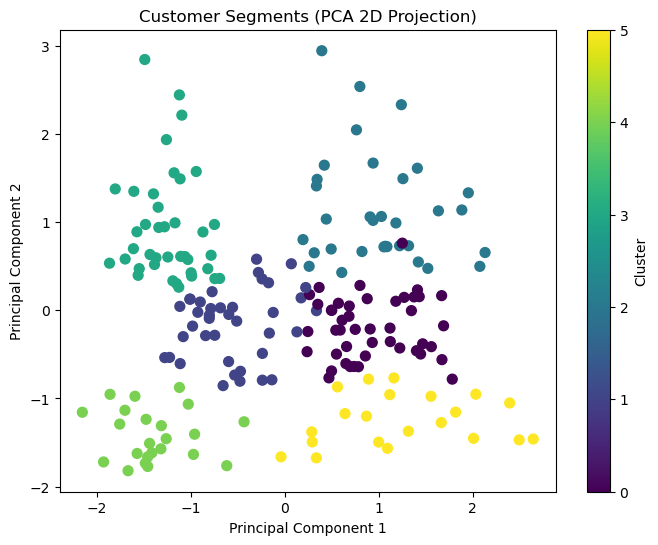

In [297]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

m["PCA1"] = X_pca[:,0]
m["PCA2"] = X_pca[:,1]

plt.figure(figsize=(8,6))
plt.scatter(m["PCA1"], m["PCA2"], c=m["Cluster"], cmap="viridis", s=50)
plt.title("Customer Segments (PCA 2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()


### Clustering with Age + Spending Score  

- Performed clustering using only **Age and Spending Score**.  
- Helps identify **young high-spenders** vs **older low-spenders**.  
- Silhouette score indicates how well this segmentation separates customers.  


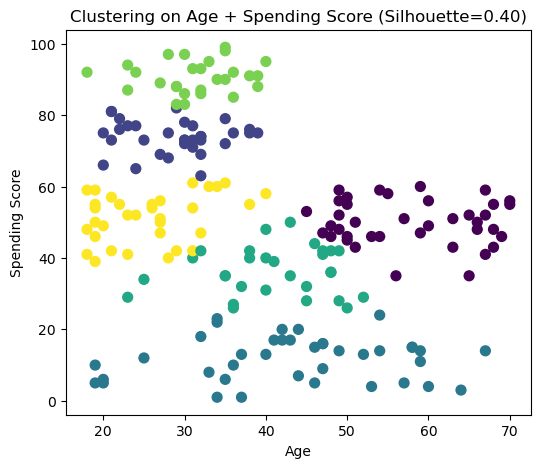

In [298]:
X1 = m[['Age', 'Spending Score']]
kmeans1 = KMeans(n_clusters=best_k, random_state=42)
labels1 = kmeans1.fit_predict(X1)
score1 = silhouette_score(X1, labels1)
plt.figure(figsize=(6,5))
plt.scatter(X1['Age'], X1['Spending Score'], c=labels1, cmap='viridis', s=50)
plt.title(f"Clustering on Age + Spending Score (Silhouette={score1:.2f})")
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.show()


###  Clustering with Income + Spending Score  

- Used **Annual Income and Spending Score** for clustering.  
- Clearly separates **premium customers (high income, high spending)** from **budget-conscious customers**.  
- Silhouette score shows how well this segmentation captures business-relevant groups.  


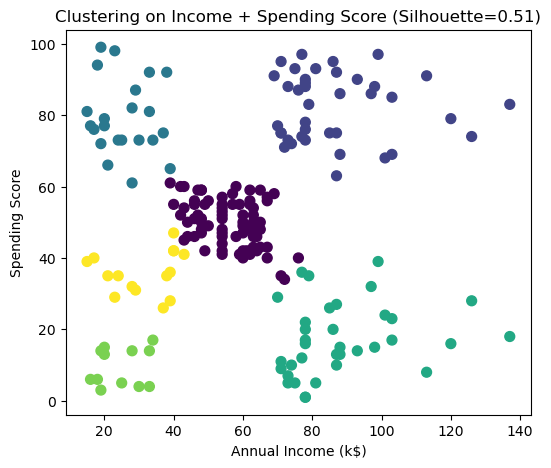

In [299]:
X2 = m[['Annual Income', 'Spending Score']]
kmeans2 = KMeans(n_clusters=best_k, random_state=42)
labels2 = kmeans2.fit_predict(X2)
score2 = silhouette_score(X2, labels2)

plt.figure(figsize=(6,5))
plt.scatter(X2['Annual Income'], X2['Spending Score'], c=labels2, cmap='viridis', s=50)
plt.title(f"Clustering on Income + Spending Score (Silhouette={score2:.2f})")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score")
plt.show()

### Saving the Model  

- Scaled the features using **StandardScaler**.  
- Trained **K-Means with 5 clusters** on the dataset.  
- Saved both the **trained model** and **scaler** using `pickle` for later use.  
- This allows deployment in a dashboard or app where new customer data can be clustered instantly.  


In [300]:
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)
pickle.dump(kmeans, open("kmeans_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))
print("✅ Model and scaler saved successfully")


✅ Model and scaler saved successfully


In [301]:
model = pickle.load(open("kmeans_model.pkl", "rb"))
scaler = pickle.load(open("scaler.pkl", "rb"))


###  Cluster Profiling  

- Assigned cluster labels back to the dataset.  
- Computed the **average Age, Income, and Spending Score** for each cluster.  
- This profiling helps interpret the nature of customer groups (e.g., Premium, Budget, Potential).  


In [302]:
m["Cluster"] = kmeans.labels_
cluster_profile = m.groupby("Cluster")[["Age", "Annual Income", "Spending Score"]].mean().reset_index()
cluster_profile


,Cluster,Age,Annual Income,Spending Score
0,0,55.275862,47.620690,41.706897
1,1,32.875000,86.100000,81.525000
2,2,25.769231,26.115385,74.846154
3,3,26.733333,54.311111,40.911111
4,4,44.387097,89.774194,18.483871


###  Segment Naming & Business Recommendations  

- Added **business-friendly labels** to each cluster for easy interpretation.  
- Attached **marketing strategies** tailored to each group:  
  - **Premium Customers** → Luxury offers, exclusivity campaigns.  
  - **Budget Customers** → Discounts and bundle offers.  
  - **Potential Customers** → Engagement campaigns and loyalty rewards.  
  - **Impulsive Shoppers** → Social media ads and flash sales.  
  - **Practical Shoppers** → Balanced offers and family packs.  


In [303]:
cluster_profile["Segment Name"] = [
    "Premium Customers",       
    "Budget Customers",        
    "Potential Customers",     
    "Impulsive Shoppers",      
    "Practical Shoppers"       
]
cluster_profile["Recommendation"] = [
    "Luxury offers, exclusivity campaigns",
    "Discounts, bundle offers",
    "Engagement campaigns, loyalty rewards",
    "Social media ads, flash sales",
    "Balanced offers, family packs"
]

cluster_profile


,Cluster,Age,Annual Income,Spending Score,Segment Name,Recommendation
0,0,55.275862,47.620690,41.706897,Premium Customers,"Luxury offers, exclusivity campaigns"
1,1,32.875000,86.100000,81.525000,Budget Customers,"Discounts, bundle offers"
2,2,25.769231,26.115385,74.846154,Potential Customers,"Engagement campaigns, loyalty rewards"
3,3,26.733333,54.311111,40.911111,Impulsive Shoppers,"Social media ads, flash sales"
4,4,44.387097,89.774194,18.483871,Practical Shoppers,"Balanced offers, family packs"


###  Styled Cluster Profile Table  

Here we create a **styled summary table** of customer clusters.  
- Each row shows the **average profile** (Age, Income, Spending Score).  
- Business-friendly **segment names** and **recommended strategies** are added.  
- The table is styled for better readability in the notebook.  


In [304]:
import matplotlib.pyplot as plt
styled_table = cluster_profile.style.set_caption("📊 Customer Segmentation with Business Recommendations")
styled_table


,Cluster,Age,Annual Income,Spending Score,Segment Name,Recommendation
0,0,55.275862,47.620690,41.706897,Premium Customers,"Luxury offers, exclusivity campaigns"
1,1,32.875000,86.100000,81.525000,Budget Customers,"Discounts, bundle offers"
2,2,25.769231,26.115385,74.846154,Potential Customers,"Engagement campaigns, loyalty rewards"
3,3,26.733333,54.311111,40.911111,Impulsive Shoppers,"Social media ads, flash sales"
4,4,44.387097,89.774194,18.483871,Practical Shoppers,"Balanced offers, family packs"
